In [1]:
import mlrose_hiive as mlh
import numpy as np
import time
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt 
import re

import plotly.express as px
import random

In [284]:
# Define the fitness functions 

# Count Ones
fitness_ones = mlh.OneMax()
n_ones=[30]
params_ones=[{'n_ones':n_one} for n_one in n_ones]
problem_ones=[('CountOnes',mlh.DiscreteOpt(param.get('n_ones'), fitness_ones, maximize=True, max_val=2),param) for param in params_ones]

# knap sack
num_items_mmc_special_run=30
num_items=[10]
max_weight_pcts = [0.6]
weights,values=[(1,15)],[(1,15)] # min and max for weight and value parameters
def get_knapsack_problem(param):
    num_items=param.get('num_items')
    max_weight_pct=param.get('max_weight_pct')
    weights=np.random.randint(param.get('weight')[0],param.get('weight')[1],num_items)
    values=np.random.randint(param.get('value')[0],param.get('value')[1],num_items)
    fitness_knap = mlh.Knapsack(weights, values, max_weight_pct)
    max_val=np.floor(max(values)/min(weights))
    return (mlh.DiscreteOpt(num_items, fitness_knap, maximize=True, max_val=max_val))

params_knap=[{'num_items':num_item,'max_weight_pct':max_weight_pct,'weight':weight,'value':value} for num_item in num_items for max_weight_pct in max_weight_pcts for weight in weights for value in values]
problem_knap=[('Knapsack',get_knapsack_problem(param),param) for param in params_knap]

#flip flop
params_flop=[{'n_bits':n_bit} for n_bit in[30]]
fitness_flop = mlh.FlipFlop()
problem_flop=[('FlipFlop',mlh.DiscreteOpt(param.get('n_bits'), fitness_flop, maximize=True, max_val=2),param) for param in params_flop]

def run_search(algo,params,problem,init=None):
    print('running:' + str(params)+'for problem '+str(problem[0]))
    
    if init=='all_zeros' and problem[0]=='Knapsack':
        init_state=np.zeros(problem[2].get('num_items'))
    elif init=='all_ones' and problem[0]=='Knapsack':
        init_state=np.ones(problem[2].get('num_items'))
    else: 
        init_state=None
    
    start = time.time()
    if algo=='rhc':
        output=mlh.random_hill_climb(problem[1], max_attempts=params.get('max_attempts'),restarts=params.get('restarts'),init_state=init_state, curve=True, random_state=None)
    elif algo=='sa':
        output=mlh.simulated_annealing(problem[1], schedule=params.get('schedule'), max_attempts=params.get('max_attempts'), init_state=init_state, curve=True, random_state=None)
    elif algo=='ga':
        output=mlh.genetic_alg(problem[1], pop_size=params.get('pop_size'), mutation_prob=params.get('mutation_prob'), max_attempts=params.get('max_attempts'),curve=True, random_state=None)
    elif algo=='mmc':
        output=mlh.mimic(problem[1], pop_size=params.get('pop_size'), keep_pct=params.get('keep_perc'), max_attempts=params.get('max_attempts'), curve=True, random_state=None)
    end = time.time()
    fit_time=end-start
    result=pd.DataFrame(data={'problem':problem[0],'problem_params':[problem[2]],'init_state':str(init),'solver_params':[params],'solution':[output[0]],'value':[output[1]],'value_curve':[output[2]],'fit_time':[fit_time]})
    return(result)




In [40]:
# rhc
max_attempts_rhc=[10,50,100,500,1000]
restarts_rhc=[1,10,100,500,1000]
params_rhc=[{'max_attempts':attempt,'restarts':restart} for attempt in max_attempts_rhc for restart in restarts_rhc]
inits_rhc=['all_zeros','all_ones','none']
output_rhc=[run_search('rhc',param,problem,init) for problem in problem_knap for param in params_rhc for init in inits_rhc]+[run_search('rhc',param,problem) for problem in proble_ones+problem_flop for param in params_rhc]
output_rhc_pd=pd.concat(output_rhc)
output_rhc_pd.to_csv('results_fitness/output_rhc_pd.csv')


#sa
schedules_sa=[fnc(init_temp=init_temp, decay=decay, min_temp=0) for init_temp in[3,5,10,20] for decay in [0.6,0.8,0.9,0.95,0.99,0.995] for fnc in[mlh.GeomDecay,mlh.ArithDecay]]
max_attempts_sa=[1,10,50,100,500,1000]
params_sa=[{'max_attempts':attempt,'schedule':schedule} for attempt in max_attempts_sa for schedule in schedules_sa]
inits_sa=['all_zeros','all_ones','none']
output_sa=[run_search('sa',param,problem,init) for param in params_sa for problem in problem_knap for init in inits_sa]+[run_search('sa',param,problem) for param in params_sa for problem in problem_ones+problem_flop]
output_sa_pd=pd.concat(output_sa)
output_sa_pd.to_csv('results_fitness/output_sa_pd.csv')

#genetic
pop_sizes_ga=[20,50,100,200,500,1000]
mutation_probs_ga=[0.02,0.05,0.1,0.2,0.3,0.4]
max_attempts_ga=[1,10,50,100,500,1000]
params_ga=[{'pop_size':pop_size,'mutation_prob':mutation_prob,'max_attempts':max_attempt} for pop_size in pop_sizes_ga for mutation_prob in mutation_probs_ga for max_attempt in max_attempts_ga]
output_ga=[run_search('ga',param,problem) for param in params_ga for problem in problem_knap+problem_ones+problem_flop]
output_ga_pd=pd.concat(output_ga)
output_ga_pd.to_csv('results_fitness/output_ga_pd.csv')


# mimic
pop_sizes_mmc=[20,50,100,200]
keep_pct_mmc=[0.02,0.05,0.1,0.2,0.3,0.4]
max_attempts_mmc=[1,10,50,100,250]
params_mmc=[{'pop_size':pop_size,'keep_perc':keep_pct,'max_attempts':max_attempt} for pop_size in pop_sizes_mmc for keep_pct in keep_pct_mmc for max_attempt in max_attempts_mmc]
output_mmc=[run_search('mmc',param,problem) for param in params_mmc for problem in problem_knap+problem_ones+problem_flop]
output_mmc_pd=pd.concat(output_mmc)
output_mmc_pd.to_csv('results_fitness/output_mmc_pd.csv')


running:{'pop_size': 50, 'keep_perc': 0.3, 'max_attempts': 1}for problem CountOnes
running:{'pop_size': 50, 'keep_perc': 0.3, 'max_attempts': 1}for problem Knapsack
running:{'pop_size': 200, 'keep_perc': 0.3, 'max_attempts': 50}for problem FlipFlop


In [241]:
# Parsing the result files
results_rhc=pd.read_csv('results_fitness/output_rhc_pd.csv')
results_sa=pd.read_csv('results_fitness/output_sa_pd.csv')
results_ga=pd.read_csv('results_fitness/output_ga_pd.csv')
results_mmc=pd.read_csv('results_fitness/output_mmc_pd.csv')
results_mmc2=pd.read_csv('results_fitness/output_mmc2_pd.csv')

def parse_solver_params(string):
    result=re.sub(r'(Geom|Arith)(.*)(\})', r"'\1 \2'\3",string) if re.search('Decay',string) else string
    return result

def explode_params(a_problem):
    a_problem['solver_params']=[ast.literal_eval(parse_solver_params(row)) for row in a_problem['solver_params']]
    a_problem=pd.concat([a_problem.drop(['solver_params'],axis=1),a_problem['solver_params'].apply(pd.Series)],axis=1)
    if 'schedule' in a_problem.columns:
        a_problem['schedule_type']=[re.search('(Geom|Arith)( Decay\()(init_temp=)(.*)(, decay=)(.*)(, min_)',row).group(1) for row in a_problem['schedule']]
        a_problem['init_temp']=[float(re.search('(Geom|Arith)( Decay\()(init_temp=)(.*)(, decay=)(.*)(, min_)',row).group(4)) for row in a_problem['schedule']]
        a_problem['decay']=[float(re.search('(Geom|Arith)( Decay\()(init_temp=)(.*)(, decay=)(.*)(, min_)',row).group(6)) for row in a_problem['schedule']]
        a_problem['is_geometric']=[1 if row=='Geom' else 0 for row in  a_problem['schedule_type']]
    return(a_problem)

def parse_problem_params(a_dict):
    if 'num_items' in a_dict.keys():
        key='num_items'
    elif 'n_ones' in a_dict.keys():
        key='n_ones'
    elif 'n_bits' in a_dict.keys():
        key='n_bits'
    return(a_dict.get(key))

def parse_results(results,algorithm_name):
    problems=results[['problem','problem_params']].drop_duplicates().reset_index()
    problems=problems.drop(['index'],axis=1)
    problems['results']=[results[(results['problem_params']==problems.iloc[i][1]) & (results['problem']==problems.iloc[i][0])] for i in range(len(problems))]
    problems['results']=[explode_params(a_problem) for a_problem in problems['results']]
    problems['problem_size']=[parse_problem_params(ast.literal_eval(row)) for row in problems['problem_params']]
    problems=problems.drop(['problem_params'],axis=1)
    problems['algorithm_name']=algorithm_name
    return(problems)

algorithms=[('random_hill_climb',results_rhc),('simulated_annealing',results_sa),('genetic',results_ga),('mimic',results_mmc)]
problems=[parse_results(algorithm[1],algorithm[0]) for algorithm in algorithms]
problems=pd.concat(problems)
problems.iloc[0]['results']




Unnamed: 0   problem                                     problem_params  \
0            0  Knapsack  {'num_items': 3, 'max_weight_pct': 0.6, 'weigh...   
1            0  Knapsack  {'num_items': 3, 'max_weight_pct': 0.6, 'weigh...   
2            0  Knapsack  {'num_items': 3, 'max_weight_pct': 0.6, 'weigh...   
3            0  Knapsack  {'num_items': 3, 'max_weight_pct': 0.6, 'weigh...   
4            0  Knapsack  {'num_items': 3, 'max_weight_pct': 0.6, 'weigh...   
..         ...       ...                                                ...   
70           0  Knapsack  {'num_items': 3, 'max_weight_pct': 0.6, 'weigh...   
71           0  Knapsack  {'num_items': 3, 'max_weight_pct': 0.6, 'weigh...   
72           0  Knapsack  {'num_items': 3, 'max_weight_pct': 0.6, 'weigh...   
73           0  Knapsack  {'num_items': 3, 'max_weight_pct': 0.6, 'weigh...   
74           0  Knapsack  {'num_items': 3, 'max_weight_pct': 0.6, 'weigh...   

   init_state    solution  value  \
0   all_zeros  [1. 0. 1.]   20.0   
1    all_ones  [1. 0. 1.]   20.0   
2        none     [1 0 1]   20.0   
3   all_zeros  [1. 0. 1.]   20.0   
4    all_ones  [1. 0. 1.]   20.0   
..        ...         ...    ...   
70   all_ones  [1. 0. 1.]   20.0   
71       none     [1 0 1]   20.0   
72  all_zeros  [1. 0. 1.]   20.0   
73   all_ones  [1. 0. 1.]   20.0   
74       none     [1 0 1]   20.0   

                                          value_curve   fit_time  \
0   [ 8. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]   0.002166   
1       [20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]   0.001999   
2           [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]   0.000999   
3   [12. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]   0.005002   
4       [20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]   0.006003   
..                                                ...        ...   
70                      [ 0.  0. 20. ... 20. 20. 20.]  12.121109   
71                      [ 0.  0.  0. ... 20. 20. 20.]  13.807658   
72                      [ 8.  8.  8. ... 20. 20. 20.]  30.387350   
73                      [20. 20. 20. ... 20. 20. 20.]  30.479286   
74  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 20. 2...  33.114118   

    max_attempts  restarts  
0             10         1  
1             10         1  
2             10         1  
3             10        10  
4             10        10  
..           ...       ...  
70          1000       500  
71          1000       500  
72          1000      1000  
73          1000      1000  
74          1000      1000  

[75 rows x 10 columns]

In [5]:
def get_sensitivity(problem,index,column,value,subtitle='',filter_init=None):
    problem=problem if filter_init==None else problem[problem['init_state']==filter_init]
    sns.heatmap(problem.pivot(index=index, columns=column, values=value),annot=True)
    plt.suptitle(value+' Sensitivity: '+ index +' vs '+ column)
    plt.title(subtitle)
    plt.show()
    
def hp_sensitivity(algorithm_name,problem_name,index,column,init=None):
    results=problems[(problems['algorithm_name']==algorithm_name) & (problems['problem']==problem_name)]
    [get_sensitivity(results[results['problem_size']==size]['results'].iloc[0],'max_attempts','restarts','value','Problem Size: '+str(size),init) for size in results['problem_size']]
    [get_sensitivity(results[results['problem_size']==size]['results'].iloc[0],'max_attempts','restarts','fit_time','Problem Size: '+str(size),init) for size in results['problem_size']]

def get_best_params(result,params):
    return(result.sort_values(['value','fit_time'],ascending=[False,True]).iloc[0][params])
    


In [243]:
# RHC Algorithm 
def best_inits(algorithm_name,problem_name):
    results=problems[(problems['algorithm_name']==algorithm_name) & (problems['problem']==problem_name)]
    results_init=pd.DataFrame([results[results['problem_size']==size]['results'].iloc[0].groupby('init_state')['value'].max() for size in results['problem_size']])
    results_init['problem_size']=[3,5,10]
    return(results_init)

hp_sensitivity('random_hill_climb','CountOnes','max_attempts','restarts')
best_inits('random_hill_climb','Knapsack')
hp_sensitivity('random_hill_climb','Knapsack','max_attempts','restarts','all_zeros')
hp_sensitivity('random_hill_climb','FlipFlop','max_attempts','restarts')

# Best parameters by problem size
results=problems[(problems['algorithm_name']=='random_hill_climb') & (problems['problem']=='FlipFlop')]
params=['max_attempts','restarts','init_state']
output=pd.DataFrame([get_best_params(results[results['problem_size']==problem_size]['results'].iloc[0].reset_index(),params) for problem_size in results['problem_size']]) 
output['problem_size']=[problem_size for problem_size in results['problem_size']]
output[['problem_size']+params]


problem_size  max_attempts  restarts init_state
0             5            10         1       None
1            10            10        10       None
9            30            50      1000       None

In [247]:
# # Simulated Annealing

# CountOnes
results=problems[(problems['algorithm_name']=='simulated_annealing') & (problems['problem']=='CountOnes')]
results=results[results['problem_size']==30]['results'].iloc[0].reset_index()
best_output=results.iloc[results.groupby(['max_attempts','schedule_type']).idxmax()['value']]

# get_sensitivity(best_output,'max_attempts','schedule_type','value','Problem Size: 30')
# get_sensitivity(best_output,'max_attempts','schedule_type','fit_time','Problem Size: 30')

# best_output=results.iloc[results.groupby(['init_temp','decay']).idxmax()['value']]

# get_sensitivity(best_output,'init_temp','decay','value','Problem Size: 30')
# get_sensitivity(best_output,'init_temp','decay','fit_time','Problem Size: 30')

# Best parameters by problem size
results=problems[(problems['algorithm_name']=='simulated_annealing') & (problems['problem']=='CountOnes')]
params=['schedule_type','init_temp','decay','max_attempts','value','fit_time']
output=pd.DataFrame([get_best_params(results[results['problem_size']==problem_size]['results'].iloc[0].reset_index(),params) for problem_size in results['problem_size']]) 
output['problem_size']=[problem_size for problem_size in results['problem_size']]
output[['problem_size']+params]


problem_size schedule_type  init_temp  decay  max_attempts  value  \
0               3          Geom        3.0   0.60             1   20.0   
705             5         Arith       20.0   0.95           500   64.0   
768            10          Geom        5.0   0.90          1000  204.0   

     fit_time  
0    0.000000  
705  0.000000  
768  0.073174

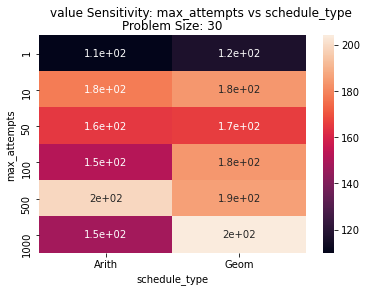

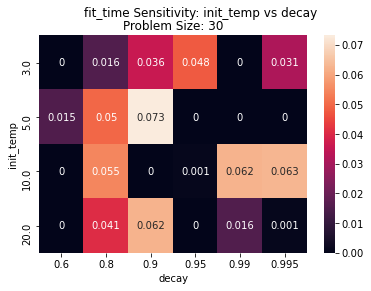

problem_size schedule_type  init_temp  decay  max_attempts  value  \
0               3          Geom        3.0   0.60             1   20.0   
705             5         Arith       20.0   0.95           500   64.0   
768            10          Geom        5.0   0.90          1000  204.0   

     fit_time  
0    0.000000  
705  0.000000  
768  0.073174

In [14]:
# # Simulated Annealing


# Knapsack
results=problems[(problems['algorithm_name']=='simulated_annealing') & (problems['problem']=='Knapsack')]
results=results[results['problem_size']==10]['results'].iloc[0].reset_index()
best_output=results.iloc[results.groupby(['max_attempts','schedule_type']).idxmax()['value']]

get_sensitivity(best_output,'max_attempts','schedule_type','value','Problem Size: 30')
get_sensitivity(best_output,'max_attempts','schedule_type','fit_time','Problem Size: 30')

best_output=results.iloc[results.groupby(['init_temp','decay']).idxmax()['value']]

get_sensitivity(best_output,'init_temp','decay','value','Problem Size: 30')
get_sensitivity(best_output,'init_temp','decay','fit_time','Problem Size: 30')

# Best parameters by problem size
results=problems[(problems['algorithm_name']=='simulated_annealing') & (problems['problem']=='Knapsack')]
params=['schedule_type','init_temp','decay','max_attempts','value','fit_time']
output=pd.DataFrame([get_best_params(results[results['problem_size']==problem_size]['results'].iloc[0].reset_index(),params) for problem_size in results['problem_size']]) 
output['problem_size']=[problem_size for problem_size in results['problem_size']]
output[['problem_size']+params]

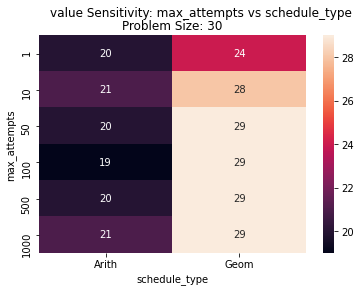

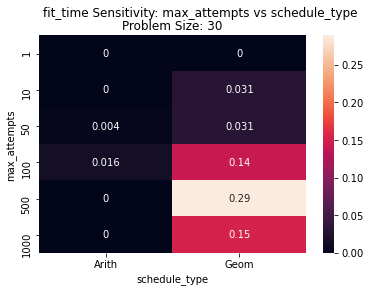

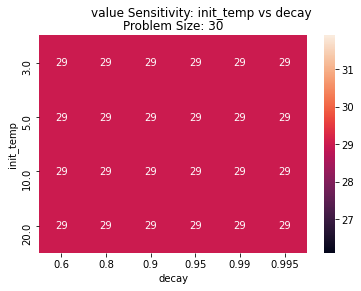

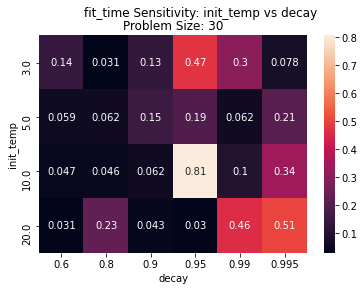

problem_size schedule_type  init_temp  decay  max_attempts  value  \
4               5          Geom        3.0    0.9             1    4.0   
48             10          Geom        3.0    0.6            10    9.0   
160            30          Geom        5.0    0.9           100   29.0   

     fit_time  
4    0.000000  
48   0.000000  
160  0.016278

In [7]:
# # Simulated Annealing
# Flip Flop
results=problems[(problems['algorithm_name']=='simulated_annealing') & (problems['problem']=='FlipFlop')]
results=results[results['problem_size']==30]['results'].iloc[0].reset_index()
best_output=results.iloc[results.groupby(['max_attempts','schedule_type']).idxmax()['value']]

get_sensitivity(best_output,'max_attempts','schedule_type','value','Problem Size: 30')
get_sensitivity(best_output,'max_attempts','schedule_type','fit_time','Problem Size: 30')

best_output=results.iloc[results.groupby(['init_temp','decay']).idxmax()['value']]

get_sensitivity(best_output,'init_temp','decay','value','Problem Size: 30')
get_sensitivity(best_output,'init_temp','decay','fit_time','Problem Size: 30')

# Best parameters by problem size
results=problems[(problems['algorithm_name']=='simulated_annealing') & (problems['problem']=='FlipFlop')]
params=['schedule_type','init_temp','decay','max_attempts','value','fit_time']
output=pd.DataFrame([get_best_params(results[results['problem_size']==problem_size]['results'].iloc[0].reset_index(),params) for problem_size in results['problem_size']]) 
output['problem_size']=[problem_size for problem_size in results['problem_size']]
output[['problem_size']+params]

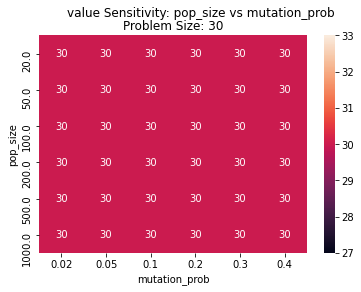

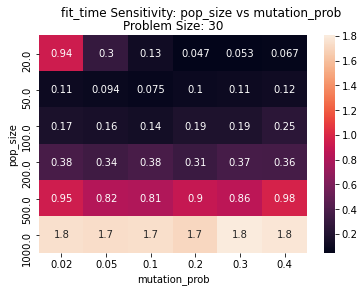

problem_size  pop_size  mutation_prob  max_attempts  value  fit_time
12             5      20.0            0.1           1.0    5.0  0.000000
48            10      50.0            0.1           1.0   10.0  0.000000
19            30      20.0            0.2          10.0   30.0  0.046874

In [9]:
# # Genetic Algorithm

# Count Ones
results=problems[(problems['algorithm_name']=='genetic') & (problems['problem']=='CountOnes')]
results=results[results['problem_size']==30]['results'].iloc[0].reset_index()
results
best_output=results.iloc[results.groupby(['pop_size','mutation_prob']).idxmax()['value']]

get_sensitivity(best_output,'pop_size','mutation_prob','value','Problem Size: 30')
get_sensitivity(best_output,'pop_size','mutation_prob','fit_time','Problem Size: 30')


# # Best parameters by problem size
results=problems[(problems['algorithm_name']=='genetic') & (problems['problem']=='CountOnes')]
params=['pop_size','mutation_prob','max_attempts','value','fit_time']
output=pd.DataFrame([get_best_params(results[results['problem_size']==problem_size]['results'].iloc[0].reset_index(),params) for problem_size in results['problem_size']]) 
output['problem_size']=[problem_size for problem_size in results['problem_size']]
output[['problem_size']+params]

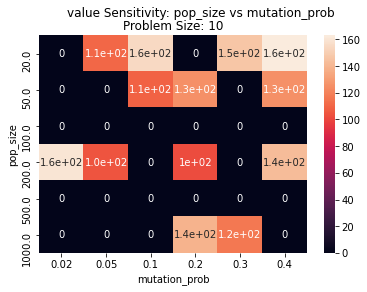

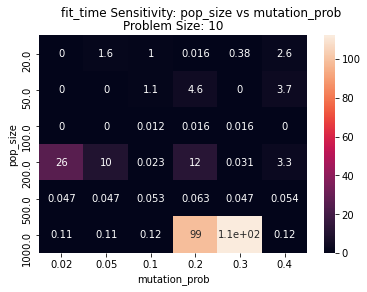

problem_size  pop_size  mutation_prob  max_attempts  value   fit_time
0               3      20.0           0.02           1.0   20.0   0.000000
160             5     500.0           0.10         500.0   60.0  19.344917
35             10      20.0           0.40        1000.0  163.0   2.591576

In [10]:
# # Genetic Algorithm

# Knapsack
results=problems[(problems['algorithm_name']=='genetic') & (problems['problem']=='Knapsack')]
results=results[results['problem_size']==10]['results'].iloc[0].reset_index()
results
best_output=results.iloc[results.groupby(['pop_size','mutation_prob']).idxmax()['value']]

get_sensitivity(best_output,'pop_size','mutation_prob','value','Problem Size: 10')
get_sensitivity(best_output,'pop_size','mutation_prob','fit_time','Problem Size: 10')


# # Best parameters by problem size
results=problems[(problems['algorithm_name']=='genetic') & (problems['problem']=='Knapsack')]
params=['pop_size','mutation_prob','max_attempts','value','fit_time']
output=pd.DataFrame([get_best_params(results[results['problem_size']==problem_size]['results'].iloc[0].reset_index(),params) for problem_size in results['problem_size']]) 
output['problem_size']=[problem_size for problem_size in results['problem_size']]
output[['problem_size']+params]

In [274]:
# # Genetic Algorithm
# Flippy Flop
results=problems[(problems['algorithm_name']=='genetic') & (problems['problem']=='FlipFlop')]
results=results[results['problem_size']==30]['results'].iloc[0].reset_index()
results
best_output=results.iloc[results.groupby(['pop_size','mutation_prob']).idxmax()['value']]

# get_sensitivity(best_output,'pop_size','mutation_prob','value','Problem Size: 30')
# get_sensitivity(best_output,'pop_size','mutation_prob','fit_time','Problem Size: 30')


# # Best parameters by problem size
results=problems[(problems['algorithm_name']=='genetic') & (problems['problem']=='FlipFlop')]
params=['pop_size','mutation_prob','max_attempts','value','fit_time']
output=pd.DataFrame([get_best_params(results[results['problem_size']==problem_size]['results'].iloc[0].reset_index(),params) for problem_size in results['problem_size']]) 
output['problem_size']=[problem_size for problem_size in results['problem_size']]
output[['problem_size']+params]






problem_size  pop_size  mutation_prob  max_attempts  value   fit_time
0               3      20.0           0.02           1.0   20.0   0.000000
160             5     500.0           0.10         500.0   60.0  19.344917
35             10      20.0           0.40        1000.0  163.0   2.591576

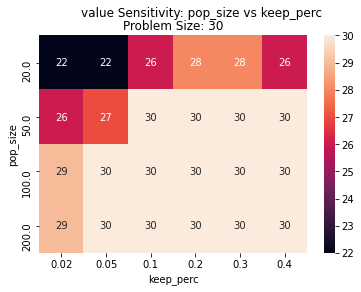

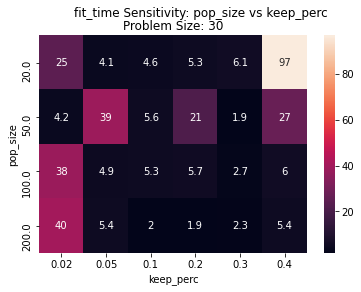

problem_size  pop_size  keep_perc  max_attempts  value  fit_time
85             5     100.0        0.4           1.0    5.0  0.007309
75            10     100.0        0.2           1.0   10.0  0.078102
50            30      50.0        0.3           1.0   30.0  1.907284

In [23]:
# # Mimic


# Count ones
results=problems[(problems['algorithm_name']=='mimic') & (problems['problem']=='CountOnes')]
results=results[results['problem_size']==30]['results'].iloc[0].reset_index()

best_output=results.iloc[results.groupby(['pop_size','keep_perc']).idxmax()['value']]

get_sensitivity(best_output,'pop_size','keep_perc','value','Problem Size: 30')
get_sensitivity(best_output,'pop_size','keep_perc','fit_time','Problem Size: 30')


# # Best parameters by problem size
results=problems[(problems['algorithm_name']=='mimic') & (problems['problem']=='CountOnes')]
params=['pop_size','keep_perc','max_attempts','value','fit_time']
output=pd.DataFrame([get_best_params(results[results['problem_size']==problem_size]['results'].iloc[0].reset_index(),params) for problem_size in results['problem_size']]) 
output['problem_size']=[problem_size for problem_size in results['problem_size']]
output[['problem_size']+params]


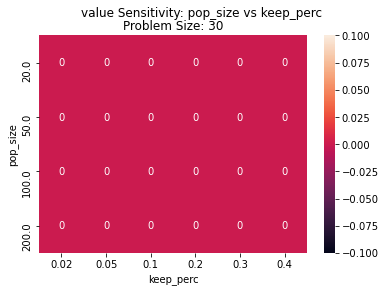

problem_size  pop_size  keep_perc  max_attempts  value  fit_time
5               3      20.0       0.05           1.0   20.0  0.000000
107             5     200.0       0.20          50.0   57.0  0.944582
50             10      50.0       0.30           1.0    0.0  0.042860

In [25]:
# # Mimic

# Knapsack
results=problems[(problems['algorithm_name']=='mimic') & (problems['problem']=='Knapsack')]
results=results[results['problem_size']==10]['results'].iloc[0].reset_index()

best_output=results.iloc[results.groupby(['pop_size','keep_perc']).idxmax()['value']]

get_sensitivity(best_output,'pop_size','keep_perc','value','Problem Size: 10')
get_sensitivity(best_output,'pop_size','keep_perc','fit_time','Problem Size: 10')


# # Best parameters by problem size
results=problems[(problems['algorithm_name']=='mimic') & (problems['problem']=='Knapsack')]
params=['pop_size','keep_perc','max_attempts','value','fit_time']
output=pd.DataFrame([get_best_params(results[results['problem_size']==problem_size]['results'].iloc[0].reset_index(),params) for problem_size in results['problem_size']]) 
output['problem_size']=[problem_size for problem_size in results['problem_size']]
output[['problem_size']+params]

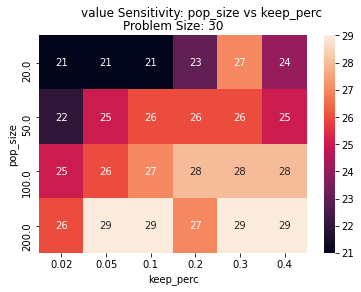

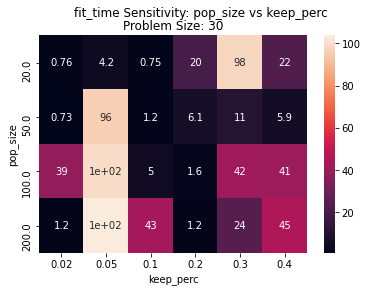

problem_size  pop_size  keep_perc  max_attempts  value   fit_time
70              5     100.0        0.1           1.0    4.0   0.015615
40             10      50.0        0.1           1.0    9.0   0.087999
112            30     200.0        0.3          50.0   29.0  23.892286

In [26]:
# # Mimic
# Flip Flop
results=problems[(problems['algorithm_name']=='mimic') & (problems['problem']=='FlipFlop')]
results=results[results['problem_size']==30]['results'].iloc[0].reset_index()

best_output=results.iloc[results.groupby(['pop_size','keep_perc']).idxmax()['value']]

get_sensitivity(best_output,'pop_size','keep_perc','value','Problem Size: 30')
get_sensitivity(best_output,'pop_size','keep_perc','fit_time','Problem Size: 30')


# # Best parameters by problem size
results=problems[(problems['algorithm_name']=='mimic') & (problems['problem']=='FlipFlop')]
params=['pop_size','keep_perc','max_attempts','value','fit_time']
output=pd.DataFrame([get_best_params(results[results['problem_size']==problem_size]['results'].iloc[0].reset_index(),params) for problem_size in results['problem_size']]) 
output['problem_size']=[problem_size for problem_size in results['problem_size']]
output[['problem_size']+params]

In [287]:
# Rerunning with best solutions because results did not save correctly
# Define Count Ones
# c1_prob=('CountOnes',mlh.DiscreteOpt(30, mlh.OneMax(), maximize=True, max_val=2),30)
# # Define Knapsack
# weights=np.random.randint(1,15,10)
# values=np.random.randint(1,15,10)
# knap_prob=('Knapsack',mlh.DiscreteOpt(10,mlh.Knapsack(weights, values, 0.6), maximize=True, max_val=np.floor(max(values)/min(weights))),10)
# #Define FlipFlop
# flop_prob=('FlipFlop',mlh.DiscreteOpt(30, mlh.OneMax(), maximize=True, max_val=2),30)
# # problems_final=[c1,knap,flop]

# # RHC
c1=(problem_ones,{'max_attempts':50,'restarts':1},None)
knap=(problem_knap,{'max_attempts':100,'restarts':100},'all_zeros')
flop=(problem_flop,{'max_attempts':50,'restarts':1000},None)
problems_final=[c1,knap,flop]
best_rhc=pd.concat([run_search('rhc',problem[1],problem[0][0]) for problem in problems_final])

# # SA
c1=(problem_ones,{'schedule':mlh.GeomDecay(init_temp=3,decay=0.6,min_temp=0),'max_attempts':50},None)
knap=(problem_knap,{'schedule':mlh.GeomDecay(init_temp=5,decay=0.9,min_temp=0),'max_attempts':1000},'all_zeros')
flop=(problem_flop,{'schedule':mlh.GeomDecay(init_temp=5,decay=0.9,min_temp=0),'max_attempts':100},None)
problems_final=[c1,knap,flop]
best_sa=pd.concat([run_search('sa',problem[1],problem[0][0]) for problem in problems_final])

# # # Genetic
c1=(problem_ones,{'pop_size':20,'mutation_prob':0.2,'max_attempts':10},)
knap=(problem_knap,{'pop_size':20,'mutation_prob':0.4,'max_attempts':1000})
flop=(problem_flop,{'pop_size':200,'mutation_prob':0.2,'max_attempts':10})
problems_final=[c1,knap,flop]
best_ga=pd.concat([run_search('ga',problem[1],problem[0][0]) for problem in problems_final])

# # Mimic
c1=(problem_ones,{'pop_size':50,'keep_perc':0.3,'max_attempts':1})
knap=(problem_knap,{'pop_size':50,'keep_perc':0.3,'max_attempts':1})
flop=(problem_flop,{'pop_size':200,'keep_perc':0.3,'max_attempts':50})
problems_final=[c1,knap,flop]
best_mmc=pd.concat([run_search('mmc',problem[1],problem[0][0]) for problem in problems_final])


running:{'max_attempts': 50, 'restarts': 1}for problem CountOnes
running:{'max_attempts': 100, 'restarts': 100}for problem Knapsack
running:{'max_attempts': 50, 'restarts': 1000}for problem FlipFlop
running:{'schedule': GeomDecay(init_temp=3, decay=0.6, min_temp=0), 'max_attempts': 50}for problem CountOnes
running:{'schedule': GeomDecay(init_temp=5, decay=0.9, min_temp=0), 'max_attempts': 1000}for problem Knapsack
running:{'schedule': GeomDecay(init_temp=5, decay=0.9, min_temp=0), 'max_attempts': 100}for problem FlipFlop
running:{'pop_size': 20, 'mutation_prob': 0.2, 'max_attempts': 10}for problem CountOnes
running:{'pop_size': 20, 'mutation_prob': 0.4, 'max_attempts': 1000}for problem Knapsack
running:{'pop_size': 200, 'mutation_prob': 0.2, 'max_attempts': 10}for problem FlipFlop
running:{'pop_size': 50, 'keep_perc': 0.3, 'max_attempts': 1}for problem CountOnes
running:{'pop_size': 50, 'keep_perc': 0.3, 'max_attempts': 1}for problem Knapsack
running:{'pop_size': 200, 'keep_perc': 0.3,

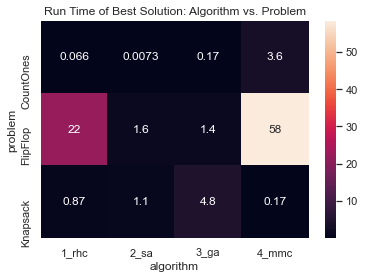

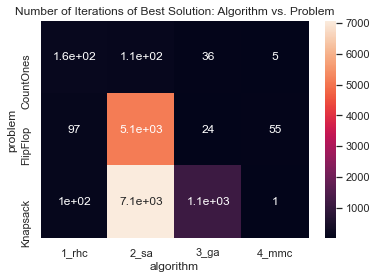

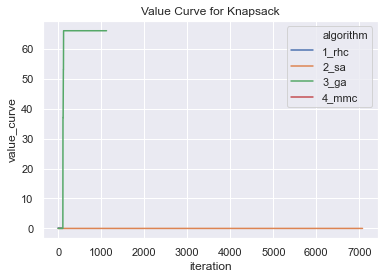

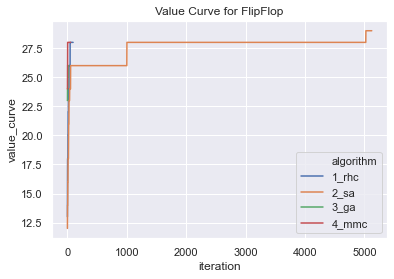

In [316]:
def parse_results(problem,problem_size):
    mmc=results_mmc2[results_mmc2['problem']==problem]
    algorithms=['random_hill_climb','simulated_annealing','genetic']
    results=pd.DataFrame([get_best_params(problems[(problems['problem']==problem)&(problems['problem_size']==problem_size)&(problems['algorithm_name']==alg_name)]['results'].iloc[0],['value_curve', 'fit_time', 'value']) for alg_name in algorithms]+[get_best_params(mmc,['value_curve', 'fit_time', 'value'])])
    
    results['algorithm']=['random_hill_climb','simulated_annealing','genetic','mimic']
    results['value_curve']=[ast.literal_eval(curve) for curve in results['value_curve'].apply(lambda x: x.replace('.',',').strip())]
    results['num_iterations']=[len(curve) for curve in results['value_curve']]
    return(results)

def explode_value_curve(results):
    results=results.explode('value_curve')
    results['value_curve']=[int(c) for c in results['value_curve']]
    results['rank_col']=[results['value_curve'].iloc[i]*100000+i for i in range(len(results))]
    results['iteration']=results.groupby('algorithm')['rank_col'].rank(method='first')
    return(results)

params=['problem','value','value_curve','fit_time']
best_all=pd.concat([best_rhc[params],best_sa[params],best_ga[params],best_mmc[params]])
best_all['algorithm']=['1_rhc']*3+['2_sa']*3+['3_ga']*3+['4_mmc']*3

best_all['num_iterations']=[len(curve) for curve in best_all['value_curve']]

sns.heatmap(best_all.pivot(index='problem',columns='algorithm',values='fit_time'),annot=True)
plt.title('Run Time of Best Solution: Algorithm vs. Problem')
plt.show()

sns.heatmap(best_all.pivot(index='problem',columns='algorithm',values='num_iterations'),annot=True)
plt.title('Number of Iterations of Best Solution: Algorithm vs. Problem')
plt.show()
sns.set()

sns.lineplot(
    data=explode_value_curve(best_all[best_all['problem']=='CountOnes']),
    x='iteration',
    y="value_curve",
    hue="algorithm",
)
plt.title('Value Curve for CountOnes')
plt.show()

sns.lineplot(
    data=explode_value_curve(best_all[best_all['problem']=='Knapsack']),
    x='iteration',
    y="value_curve",
    hue="algorithm",
)
plt.title('Value Curve for Knapsack')
plt.show()


sns.lineplot(
    data=explode_value_curve(best_all[best_all['problem']=='FlipFlop']),
    x='iteration',
    y="value_curve",
    hue="algorithm",
)
plt.title('Value Curve for FlipFlop')
plt.show()






problem                                     problem_params init_state  \
0  CountOnes                                     {'n_ones': 30}       None   
0   Knapsack  {'num_items': 10, 'max_weight_pct': 0.6, 'weig...       None   
0   FlipFlop                                     {'n_bits': 30}       None   

                           solver_params  \
0    {'schedule': 3, 'max_attempts': 50}   
0  {'schedule': 5, 'max_attempts': 1000}   
0   {'schedule': 5, 'max_attempts': 100}   

                                            solution  value  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   30.0   
0                     [4, 2, 4, 2, 1, 6, 1, 6, 5, 2]    0.0   
0  [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...   29.0   

                                         value_curve  fit_time  
0  [14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 19.0, 19....  0.007251  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  1.106277  
0  [16.0, 14.0, 14.0, 12.0, 14.0, 16.0, 16.0, 14....  1.573231

In [53]:
problems[(problems['problem']=='CountOnes')&(problems['problem_size']==30)]['results'].iloc[0]

Unnamed: 0    problem  problem_params init_state  \
275           0  CountOnes  {'n_ones': 30}       None   
276           0  CountOnes  {'n_ones': 30}       None   
277           0  CountOnes  {'n_ones': 30}       None   
278           0  CountOnes  {'n_ones': 30}       None   
279           0  CountOnes  {'n_ones': 30}       None   
280           0  CountOnes  {'n_ones': 30}       None   
281           0  CountOnes  {'n_ones': 30}       None   
282           0  CountOnes  {'n_ones': 30}       None   
283           0  CountOnes  {'n_ones': 30}       None   
284           0  CountOnes  {'n_ones': 30}       None   
285           0  CountOnes  {'n_ones': 30}       None   
286           0  CountOnes  {'n_ones': 30}       None   
287           0  CountOnes  {'n_ones': 30}       None   
288           0  CountOnes  {'n_ones': 30}       None   
289           0  CountOnes  {'n_ones': 30}       None   
290           0  CountOnes  {'n_ones': 30}       None   
291           0  CountOnes  {'n_ones': 30}       None   
292           0  CountOnes  {'n_ones': 30}       None   
293           0  CountOnes  {'n_ones': 30}       None   
294           0  CountOnes  {'n_ones': 30}       None   
295           0  CountOnes  {'n_ones': 30}       None   
296           0  CountOnes  {'n_ones': 30}       None   
297           0  CountOnes  {'n_ones': 30}       None   
298           0  CountOnes  {'n_ones': 30}       None   
299           0  CountOnes  {'n_ones': 30}       None   

                                              solution  value  \
275  [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0...   28.0   
276  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   29.0   
277  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
278  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
279  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
280  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
281  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
282  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
283  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
284  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
285  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
286  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
287  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
288  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
289  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
290  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
291  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
292  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
293  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
294  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
295  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
296  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
297  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
298  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   
299  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   30.0   

                                           value_curve   fit_time  \
275  [13. 14. 14. 15. 16. 16. 17. 17. 17. 17. 17. 1...   0.000000   
276  [17. 18. 18. 19. 19. 19. 19. 19. 19. 20. 20. 2...   0.015627   
277  [12. 13. 14. 15. 16. 16. 16. 17. 17. 17. 17. 1...   0.093746   
278  [18. 18. 18. 19. 20. 20. 20. 21. 22. 23. 23. 2...   0.535010   
279  [14. 14. 14. 15. 15. 15. 15. 16. 16. 17. 17. 1...   1.059450   
280  [16. 16. 17. 17. 17. 17. 17. 18. 19. 20. 20. 2...   0.000000   
281  [16. 16. 16. 16. 16. 16. 16. 17. 17. 17. 17. 1...   0.031245   
282  [20. 21. 21. 21. 21. 21. 21. 21. 22. 23. 23. 2...   0.316222   
283  [15. 15. 16. 17. 17. 17. 17. 17. 18. 19. 19. 2...   1.481033   
284  [19. 19. 19. 20. 21. 21. 22. 22. 22. 22. 22. 2...   2.927909   
285  [18. 18. 19. 19. 19. 19. 20. 20. 20. 21. 21. 2...   0.009001   
286